### IMPORTACIÓN DE LAS LIBRERIAS

In [139]:
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier

import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### LECTURA DEL DATASET Y TRATAMIENTO DE LOS DATOS

In [2]:
df = pd.read_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\healthcare-dataset-stroke-data.csv', index_col=0)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Con un *df.info()* observo que existen valores vacíos (NaN) en la columna *bmi*. Más adelante trataré estos valores. También veo que existen varias columnas cuyos datos son de tipo *object*, los cuales también trataré más adelante.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


Con *df.describe()* observo que no parece que haya nada fuera de lo normal, salvo algún posible outlier en la columna *avg_glucose_level* y en la columna *bmi*. Respecto a esta última tendré que ver como quedan sus datos una vez tratados los valores *NaN* que contiene.

In [4]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Empiezo el tratamiento de los datos. Lo primero que hago es obtener un recuento de los valores de las columnas que parecen contener datos binarios.

In [5]:
print('Gender: \n', df['gender'].value_counts())
print('-'*33)
print('Ever married: \n', df['ever_married'].value_counts())
print('-'*33)
print('Hypertension: \n', df['hypertension'].value_counts())
print('-'*33)
print('Heart disease: \n', df['heart_disease'].value_counts())
print('-'*33)
print('Stroke: \n', df['stroke'].value_counts())

Gender: 
 Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
---------------------------------
Ever married: 
 Yes    3353
No     1757
Name: ever_married, dtype: int64
---------------------------------
Hypertension: 
 0    4612
1     498
Name: hypertension, dtype: int64
---------------------------------
Heart disease: 
 0    4834
1     276
Name: heart_disease, dtype: int64
---------------------------------
Stroke: 
 0    4861
1     249
Name: stroke, dtype: int64


#### Tratamiento de las variables categóricas para convertirlas en variables númericas con las que poder trabajar.

En el caso de la columna *ever_married* no hay problema: contiene valores *Yes* o *No* por lo que convierto los primeros en 1s y los segundos en 0s.

In [6]:
df['married'] = np.where(df['ever_married']=='Yes', 1,0)
df.drop(columns='ever_married', inplace=True)
df['married'].value_counts()

1    3353
0    1757
Name: married, dtype: int64

En cuanto a la columna *gender*, que contiene tres categorías, como sólo existe un valor en la categoria *Other*, la sumo a la categoria *Male*. Convierto las categorías *Female* y *Male* en 1s y 0s respectivamente.

In [7]:
df['gender'] = np.where(df['gender']=='Female', 1,0)
df['gender'].value_counts()

1    2994
0    2116
Name: gender, dtype: int64

En la columna *Residence_type* hay dos categorías: *Urban* y *Rural*. Creo una nueva columna *residence_urban* que contendrá 1s en los casos en los que se cumpla la variable y 0s en aquellos casos en los que no.

In [8]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [9]:
df['residence_urban'] = np.where(df['Residence_type']=='Urban', 1,0)
df.drop(columns='Residence_type', inplace=True)
df['residence_urban'].value_counts()

1    2596
0    2514
Name: residence_urban, dtype: int64

Para la columna *work_type* aplico valores en función de la correlación que tienen las distintas opciones con la variable *target*.

In [10]:
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [11]:
# Creo un nuevo dataframe diviendo la columna work_types en tantas otras como categorías contiene. Estas nuevas columnas contienen 0s y 1s.
df_work = pd.get_dummies(df['work_type'])

# Creo un nuevo dataframe que sólo contiene la target para, más adelante, poder comparar los datos con los diferentes tipos de trabajo.
df_stroke = df['stroke']

# Hago un merge de las columnas creadas expresamente para el tratamiento de la feature "work_type".
# Con este paso tengo en un mismo dataset las diferentes categorías de *work_type* y la target stroke.
df_work_merge = pd.merge(df_work, df_stroke, how='inner', on='id')
df_work_merge.head()

,Govt_job,Never_worked,Private,Self-employed,children,stroke
id,,,,,,
9046,0,0,1,0,0,1
51676,0,0,0,1,0,1
31112,0,0,1,0,0,1
60182,0,0,1,0,0,1
1665,0,0,0,1,0,1


<AxesSubplot:>

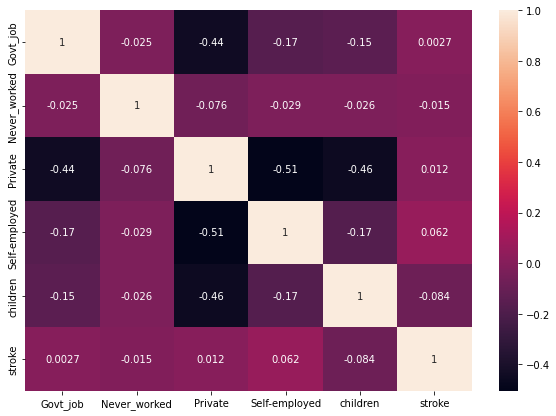

In [12]:
# Genero un mapa de calor para poder ver la correlación de los tipos de trabajo con la target.
plt.figure(figsize=(10,7))
sns.heatmap(df_work_merge.corr(), annot=True)

In [13]:
# Ahora ya puedo asignar un valor númerico a los diferentes tipos de trabajo que se ajusta a los datos en función de su correlación con la target.
work_type_dict = {'children': -2, 'Never_worked': -1, 'Govt_job': 0, 'Private': 1, 'Self-employed': 2}
df['work'] = df['work_type'].replace(work_type_dict)
df.drop(columns='work_type', inplace=True)

En la columna *smoking_status* existe una categoría *Unknown* en la que se recogen los datos para aquellas instancias sobre las que no se tiene información. Por esa razón, decido aplicar un valor númerico superior a 0 a todas las categorías, siendo el 1 para *Unknown*.

In [14]:
smoking_status_dict = {'Unknown': 1, 'formerly smoked': 2, 'never smoked': 3, 'smokes': 4}
df['smoke'] = df['smoking_status'].replace(smoking_status_dict)
df.drop(columns='smoking_status', inplace=True)

### TRATAMIENTO DEL RESTO DE VARIABLES

Decido tratar los datos *NaN* de la columna *bmi* aplicando un *KNNImputer*.

In [15]:
imputer = KNNImputer(n_neighbors = 6)
df['bmi'] = imputer.fit_transform(np.array(df['bmi']).reshape(-1,1))

Redondeo de la variable *age*.

In [16]:
df['age'] = df['age'].apply(lambda x: round(x))

Elimino las columnas de tipo *object* y me quedo sólo con las columnas que voy a utilizar para la implementación de los diferentes modelos.

In [17]:
df_clean = df.copy()

In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int32  
 1   age                5110 non-null   int64  
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   avg_glucose_level  5110 non-null   float64
 5   bmi                5110 non-null   float64
 6   stroke             5110 non-null   int64  
 7   married            5110 non-null   int32  
 8   residence_urban    5110 non-null   int32  
 9   work               5110 non-null   int64  
 10  smoke              5110 non-null   int64  
dtypes: float64(2), int32(3), int64(6)
memory usage: 419.2 KB


### EDA

En esta parte me centro en el análisis exploratorio de los datos para ver las relaciones entre las variables y la *target*.

In [19]:
# Correlación lineal
corr = np.abs(df_clean.corr()['stroke']).sort_values(ascending=True)
print(corr)

gender               0.009027
residence_urban      0.015458
smoke                0.028123
bmi                  0.038947
work                 0.093664
married              0.108340
hypertension         0.127904
avg_glucose_level    0.131945
heart_disease        0.134914
age                  0.245244
stroke               1.000000
Name: stroke, dtype: float64


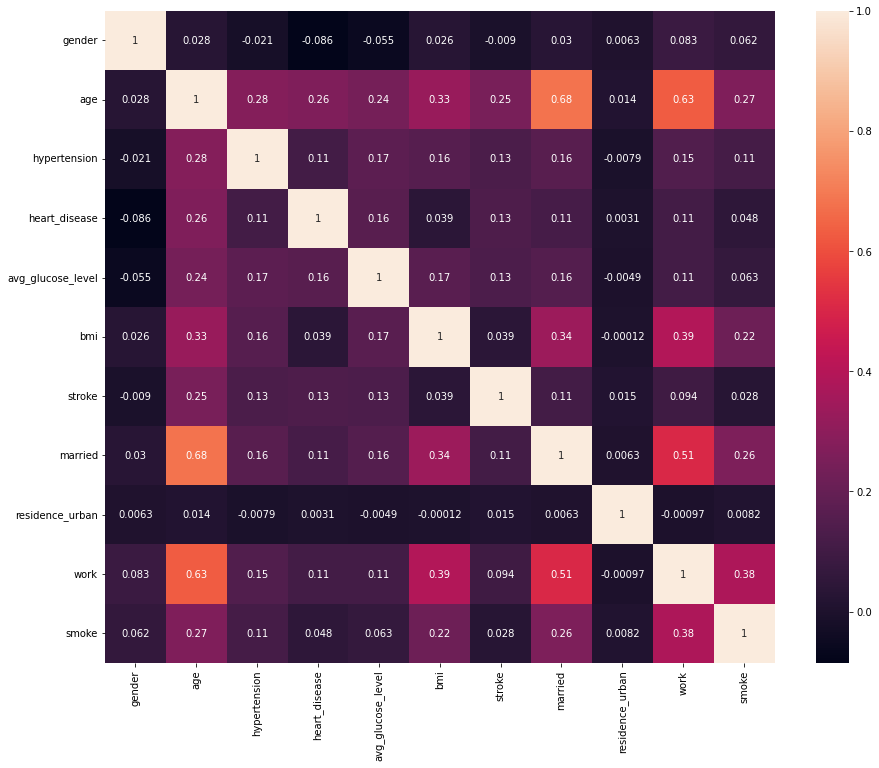

In [20]:
plt.figure(figsize=(15,12))
sns.heatmap(df_clean.corr(), annot=True);

### CREACIÓN DATASET DE TEST

In [92]:
test = df_clean.copy()
test.sort_values(by='id', inplace=True)
test = test.iloc[:2500, :]
test_target = test['stroke']
test.drop(columns=['stroke'], inplace=True)
test.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\test.csv')

In [93]:
df_test = pd.read_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\test.csv', index_col=0)
df_test.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,married,residence_urban,work,smoke
id,,,,,,,,,,
67,1,17,0,0,92.97,28.893237,0,1,1,2
77,1,13,0,0,85.81,18.600000,0,0,-2,1
84,0,55,0,0,89.17,31.500000,1,1,1,3
91,1,42,0,0,98.53,18.500000,0,1,1,3
99,1,31,0,0,108.89,52.300000,0,1,1,1


### CREACIÓN DEL DATASET CON LA TARGET DEL DATASET DE TEST

In [94]:
test_target.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\test_target.csv') 

### CREACIÓN DATASET DE TRAIN

In [95]:
train = df_clean.copy()
train.sort_values(by='id', inplace=True)
train = train.iloc[2501: , :]
train.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\train.csv') 

In [96]:
df_train = pd.read_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\train.csv', index_col=0)
df_train.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,married,residence_urban,work,smoke
id,,,,,,,,,,,
36255,0,59,0,0,118.03,35.5,1,1,0,2,4
36275,1,54,0,0,206.72,26.7,0,1,0,1,3
36298,1,48,0,0,71.93,41.7,0,1,0,2,3
36317,1,41,0,0,134.29,26.8,0,1,0,1,4
36331,0,18,0,0,70.34,24.2,0,0,0,1,1


### MODELOS

Probando el modelo sin ningún tipo de correción

In [97]:
# Definición de etiquetas
X = df_train.drop(columns=['stroke'])
y = df_train['stroke']

# Random Over Sampler para ampliar las muestras de positivos con datos sintéticos
oversample = RandomOverSampler(sampling_strategy=0.30)

X_over, y_over = oversample.fit_resample(X, y)

print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_over)))

Original dataset shape Counter({0: 2482, 1: 127})
Resampled dataset shape Counter({0: 2482, 1: 744})


In [98]:
# División train y test
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.15, random_state=42)

In [71]:
# Función para crear el modelo cada vez
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver='newton-cg')
    clf_base.fit(X_train, y_train)
    return clf_base

model = run_model(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1117
           1       0.60      0.44      0.51       334

    accuracy                           0.80      1451
   macro avg       0.72      0.68      0.69      1451
weighted avg       0.79      0.80      0.79      1451



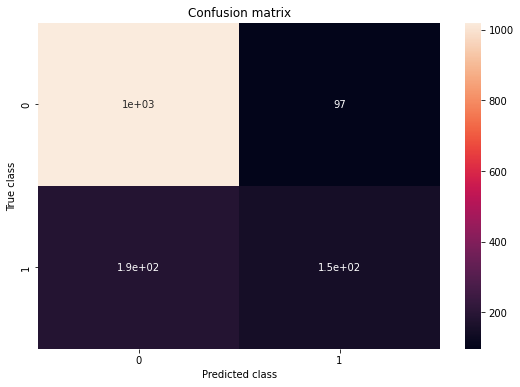

In [72]:
# Función que mostrará los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(9,6))
    sns.heatmap(conf_matrix, annot=True)
    plt.title('Confusion matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    print (classification_report(y_test, pred_y))

pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Submuestreo en la clase minoritaria.

Distribution before resampling Counter({0: 2603, 1: 782})
Distribution after resampling Counter({0: 782, 1: 782})
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1117
           1       0.49      0.64      0.56       334

    accuracy                           0.76      1451
   macro avg       0.69      0.72      0.70      1451
weighted avg       0.79      0.76      0.77      1451



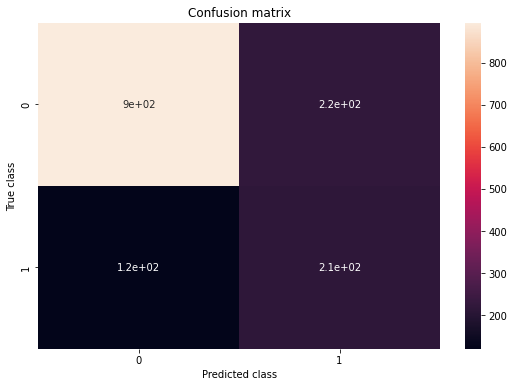

In [73]:
nr = NearMiss()

X_near, y_near = nr.fit_resample(X_train, y_train)

print ('Distribution before resampling {}'.format(Counter(y_train)))
print ('Distribution after resampling {}'.format(Counter(y_near)))

model = run_model(X_near, X_test, y_near, y_test)

y_pred = model.predict(X_test)
mostrar_resultados(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1140
           1       0.13      0.58      0.21        60

    accuracy                           0.79      1200
   macro avg       0.55      0.69      0.55      1200
weighted avg       0.93      0.79      0.84      1200



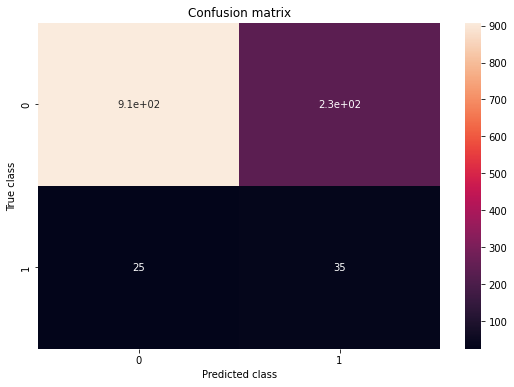

In [74]:
predicciones = model.predict(df_test)
mostrar_resultados(test_target, predicciones)

Cobinación de resampling con Smote-Tomek

Distribution before resampling Counter({0: 2603, 1: 782})
Distribution after resampling Counter({1: 2597, 0: 2597})
              precision    recall  f1-score   support

           0       0.93      0.74      0.82      1117
           1       0.48      0.81      0.60       334

    accuracy                           0.75      1451
   macro avg       0.70      0.77      0.71      1451
weighted avg       0.82      0.75      0.77      1451



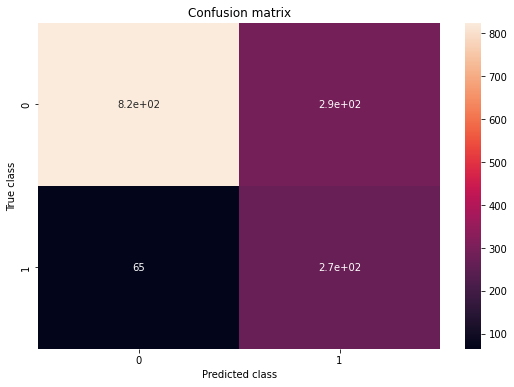

In [75]:
Sm_Tom = SMOTETomek()

X_train_res, y_train_res = Sm_Tom.fit_resample(X_train, y_train)

print ('Distribution before resampling {}'.format(Counter(y_train)))
print ('Distribution after resampling {}'.format(Counter(y_train_res)))

model = run_model(X_train_res, X_test, y_train_res, y_test)

y_pred = model.predict(X_test)
mostrar_resultados(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1140
           1       0.13      0.83      0.23        60

    accuracy                           0.72      1200
   macro avg       0.56      0.77      0.53      1200
weighted avg       0.95      0.72      0.80      1200



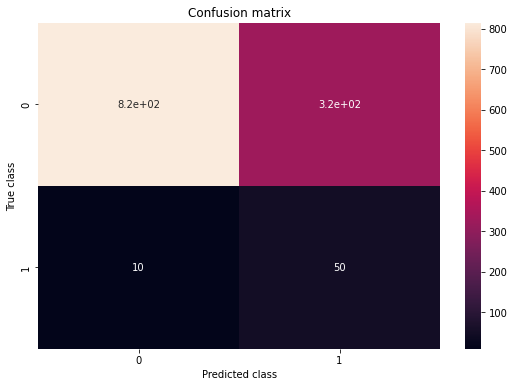

In [76]:
predicciones = model.predict(df_test)
mostrar_resultados(test_target, predicciones)

Ensamble con modelos de balanceo

              precision    recall  f1-score   support

           0       0.95      0.61      0.74       359
           1       0.45      0.91      0.60       125

    accuracy                           0.69       484
   macro avg       0.70      0.76      0.67       484
weighted avg       0.82      0.69      0.71       484



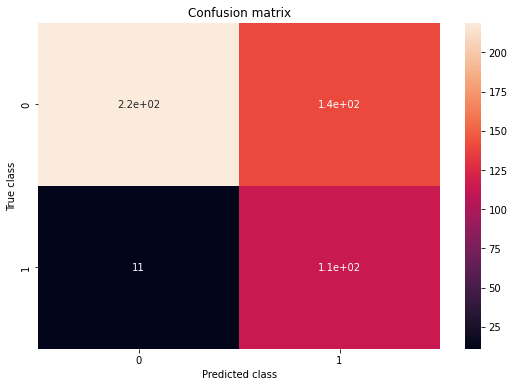

In [109]:
brf_clf = BalancedRandomForestClassifier(max_depth=2, max_leaf_nodes=2)

brf_clf.fit(X_train, y_train)

y_pred = brf_clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.60      0.75      2379
           1       0.10      0.90      0.19       121

    accuracy                           0.62      2500
   macro avg       0.55      0.75      0.47      2500
weighted avg       0.95      0.62      0.72      2500



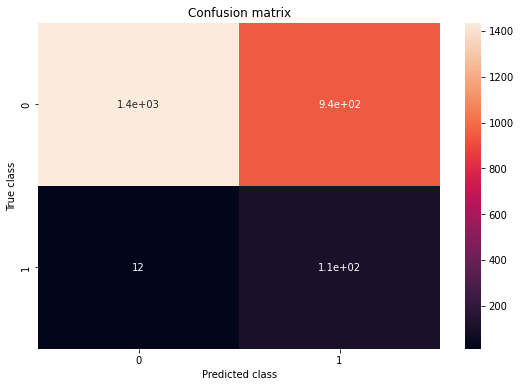

In [110]:
brf_clf_test = brf_clf.predict(test)
mostrar_resultados(test_target, brf_clf_test)

In [78]:
# def save_file(model, file_name):
#     with open(file_name, "wb") as exit_file:
#         pickle.dump(model, exit_file)

In [79]:
# save_file(bbc, 'BalancedBaggingClassifier_model')

In [81]:
adfgasd

NameError: name 'adfgasd' is not defined

### HIPERPARAMETRIZACIÓN DE LOS DATOS

In [ ]:
df_hyper = df_clean.copy()
df_hyper.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,married,residence_urban,work,smoke
id,,,,,,,,,,,
9046,0,67,0,1,228.69,36.600000,1,1,1,1,2
51676,1,61,0,0,202.21,28.893237,1,1,0,2,3
31112,0,80,0,1,105.92,32.500000,1,1,0,1,3
60182,1,49,0,0,171.23,34.400000,1,1,1,1,4
1665,1,79,1,0,174.12,24.000000,1,1,0,2,3


In [ ]:
test_hyper = df_hyper.copy()
test_hyper.sort_values(by='id', inplace=True)
test_hyper = test_hyper.iloc[:900, :]
test_hyper_target = test_hyper['stroke']
test_hyper.drop(columns=['stroke'], inplace=True)
test_hyper.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\test_hyper.csv')

In [ ]:
df_test_hyper = pd.read_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\test_hyper.csv', index_col=0)
df_test_hyper.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,married,residence_urban,work,smoke
id,,,,,,,,,,
67,1,17,0,0,92.97,28.893237,0,1,1,2
77,1,13,0,0,85.81,18.600000,0,0,-2,1
84,0,55,0,0,89.17,31.500000,1,1,1,3
91,1,42,0,0,98.53,18.500000,0,1,1,3
99,1,31,0,0,108.89,52.300000,0,1,1,1


In [ ]:
df_test_hyper.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 67 to 12449
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             900 non-null    int64  
 1   age                900 non-null    int64  
 2   hypertension       900 non-null    int64  
 3   heart_disease      900 non-null    int64  
 4   avg_glucose_level  900 non-null    float64
 5   bmi                900 non-null    float64
 6   married            900 non-null    int64  
 7   residence_urban    900 non-null    int64  
 8   work               900 non-null    int64  
 9   smoke              900 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 77.3 KB


In [ ]:
test_hyper_target.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\test_hyper_target.csv') 
test_hyper_target.value_counts()

0    852
1     48
Name: stroke, dtype: int64

In [ ]:
train_hyper = df_hyper.copy()
train_hyper.sort_values(by='id', inplace=True)
train_hyper = train_hyper.iloc[901: , :]
train_hyper.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\train_hyper.csv') 

In [ ]:
df_train_hyper = pd.read_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\train_hyper.csv', index_col=0)
df_train_hyper.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,married,residence_urban,work,smoke
id,,,,,,,,,,,
12469,1,30,0,0,74.43,44.8,0,1,1,1,3
12482,0,68,0,0,77.82,27.5,1,1,1,2,4
12487,0,65,0,0,81.06,30.1,0,1,1,1,4
12512,1,52,1,0,213.54,32.0,0,1,0,1,3
12557,1,21,0,0,91.18,25.7,0,0,1,2,3


In [ ]:
df_train_hyper.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 12469 to 72940
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4209 non-null   int64  
 1   age                4209 non-null   int64  
 2   hypertension       4209 non-null   int64  
 3   heart_disease      4209 non-null   int64  
 4   avg_glucose_level  4209 non-null   float64
 5   bmi                4209 non-null   float64
 6   stroke             4209 non-null   int64  
 7   married            4209 non-null   int64  
 8   residence_urban    4209 non-null   int64  
 9   work               4209 non-null   int64  
 10  smoke              4209 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 394.6 KB


#### RANDOMIZED SEARCH CV

In [ ]:
X_hyper = df_train_hyper.drop(columns='stroke')
y_hyper = df_train_hyper['stroke']

oversample = RandomOverSampler(sampling_strategy=0.60)

X_over_hyper, y_over_hyper = oversample.fit_resample(X_hyper, y_hyper)

X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper = train_test_split(X_over_hyper, y_over_hyper, test_size=0.35, random_state=42)

In [ ]:
# Número de árboles en el random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Número de features a tener en cuenta en cada split
max_features = ['auto', 'sqrt']

# Máximo número de niveles en el árbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Número mínimo de samples requeridos para devidir un nodo
min_samples_split = [2, 5, 10]

# Número mínimo de samples requeridos en cada hoja del nodo
min_samples_leaf = [1, 2, 4]

# Método de selección de samples para entrenar cada árbol
bootstrap = [True, False]

# Regularización de datos
penalty = ['l1', 'l2']

# Creación del random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'penalty': penalty}

In [ ]:
rfc = RandomForestClassifier()

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)

rfc_random.fit(X_train_hyper, y_train_hyper)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rfc_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [ ]:
preds_rfc_random = rfc_random.predict(X_test_hyper)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       613
           1       0.99      1.00      0.99       349

    accuracy                           1.00       962
   macro avg       0.99      1.00      1.00       962
weighted avg       1.00      1.00      1.00       962



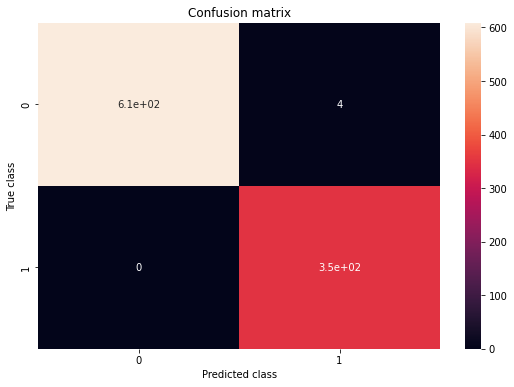

In [ ]:
mostrar_resultados(y_test_hyper, preds_rfc_random)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       852
           1       0.25      0.08      0.12        48

    accuracy                           0.94       900
   macro avg       0.60      0.53      0.55       900
weighted avg       0.91      0.94      0.92       900



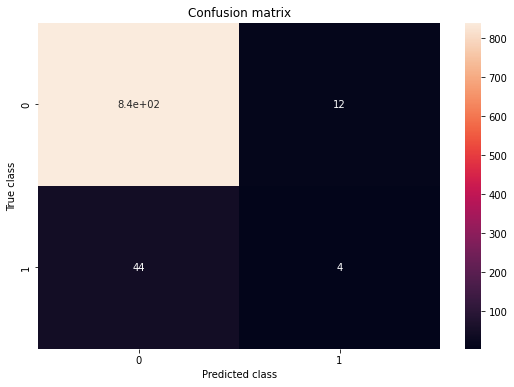

In [ ]:
preds_rfc_random_test = rfc_random.predict(df_test_hyper)
mostrar_resultados(test_hyper_target, preds_rfc_random_test)

#### GRID SEARCH

In [ ]:
# Cuadrícula de parámetros basada en los resultados del random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100, 120, 140, 160],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8,],
    'n_estimators': [100, 200, 300],
}
# Cración del modelo
rfc = RandomForestClassifier(class_weight='balanced')

# Crear una instancia del grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train_hyper, y_train_hyper)
grid_search.best_params_

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


{'bootstrap': True,
 'max_depth': 140,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
preds_gs = grid_search.predict(X_test_hyper)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1428
           1       0.95      1.00      0.98       817

    accuracy                           0.98      2245
   macro avg       0.98      0.99      0.98      2245
weighted avg       0.98      0.98      0.98      2245



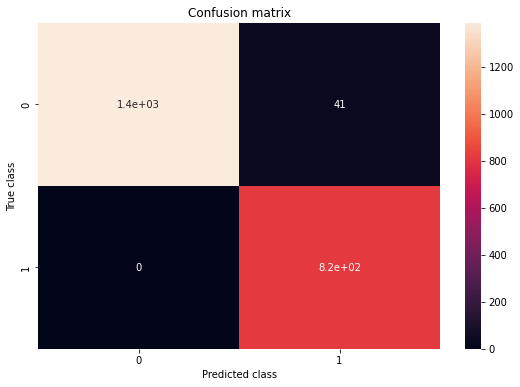

In [ ]:
mostrar_resultados(y_test_hyper, preds_gs)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       852
           1       0.22      0.25      0.24        48

    accuracy                           0.91       900
   macro avg       0.59      0.60      0.59       900
weighted avg       0.92      0.91      0.92       900



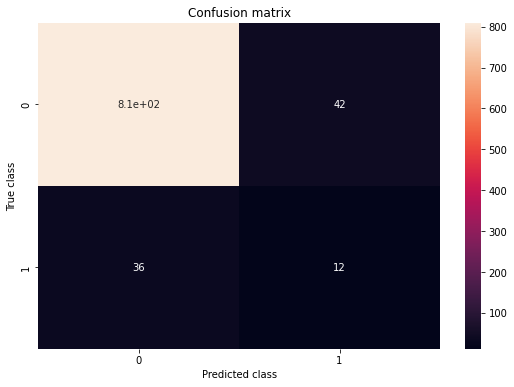

In [ ]:
preds_gs_test = grid_search.predict(df_test_hyper)
mostrar_resultados(test_hyper_target, preds_gs_test)

#### XGBOOST

In [ ]:
# Cuadrícula de parámetros basada en los resultados del random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Cración del modelo
xgb = XGBClassifier()

# Crear una instancia del grid search model
grid_search_xgb = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit del grid search a los datos
grid_search_xgb.fit(X_train_hyper, y_train_hyper)
grid_search_xgb.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[12:58:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:58:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1218
           1       0.95      1.00      0.97       706

    accuracy                           0.98      1924
   macro avg       0.97      0.98      0.98      1924
weighted avg       0.98      0.98      0.98      1924



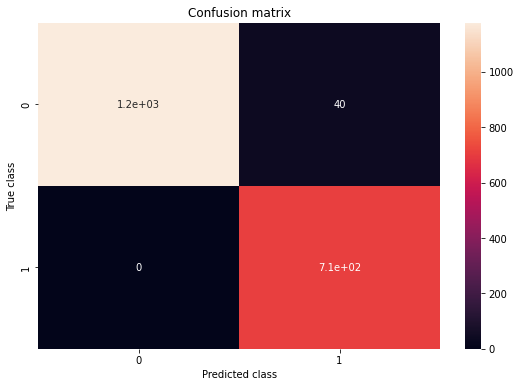

In [ ]:
preds_gs_xgb = grid_search_xgb.predict(X_test_hyper)
mostrar_resultados(y_test_hyper, preds_gs_xgb)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       852
           1       0.17      0.19      0.18        48

    accuracy                           0.91       900
   macro avg       0.56      0.57      0.56       900
weighted avg       0.91      0.91      0.91       900



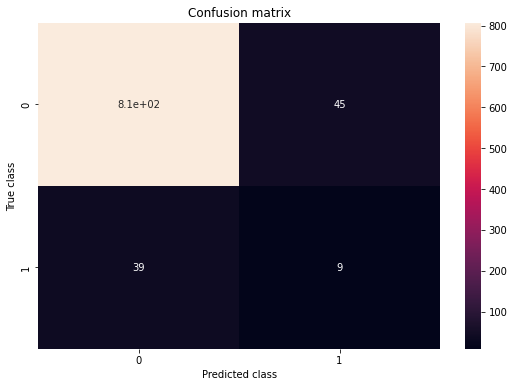

In [ ]:
preds_gs_xgb_test = grid_search_xgb.predict(df_test_hyper)
mostrar_resultados(test_hyper_target, preds_gs_xgb_test)